In [1]:
import collections
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import display
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from wordcloud import WordCloud, STOPWORDS

seed = 42
random.seed = seed

In [2]:
data = pd.read_csv("Data/tweet_emotions_preprocessed.csv", index_col=0)

display(data.head(15))

,content,sentiment
0,petronas years petronas perform huge profit,joy
1,run divine experience expect type spiritual en...,joy
2,immense sympathy general point possible proto ...,joy
3,reassure anxiety,joy
4,amuse delight,joy
5,able help chai lifeline support encouragement ...,joy
6,superior dead chicken grieve child,joy
7,giddy elegant perfectly fit pencil skirt,joy
8,imagine real life scenario emotionally connect...,joy
9,sure make content,joy


Word Cloud: joy


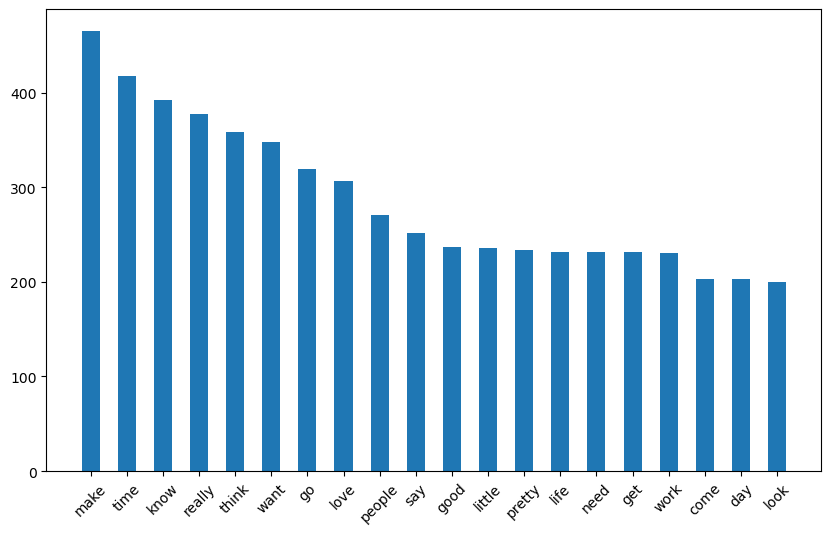

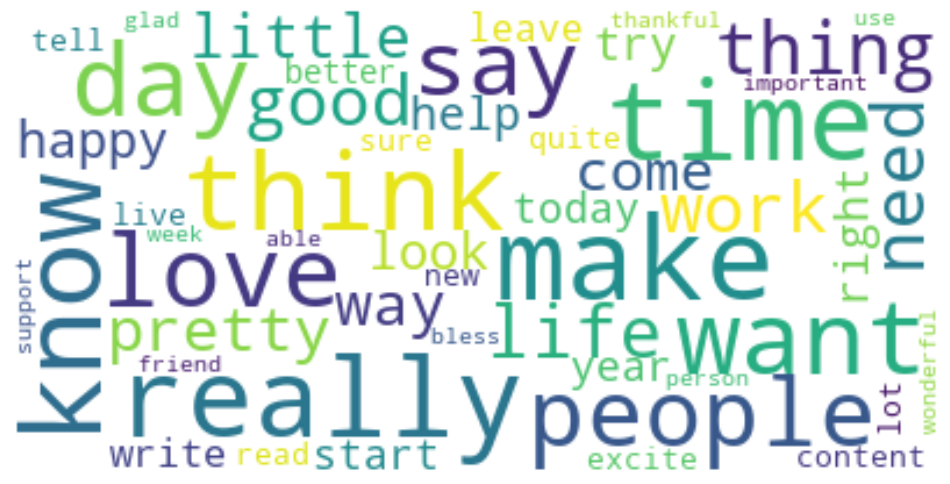

Word Cloud: sadness


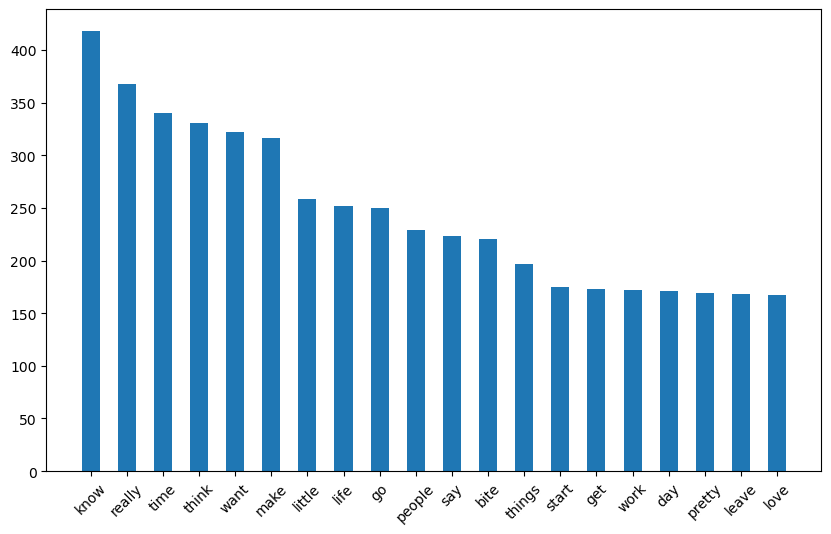

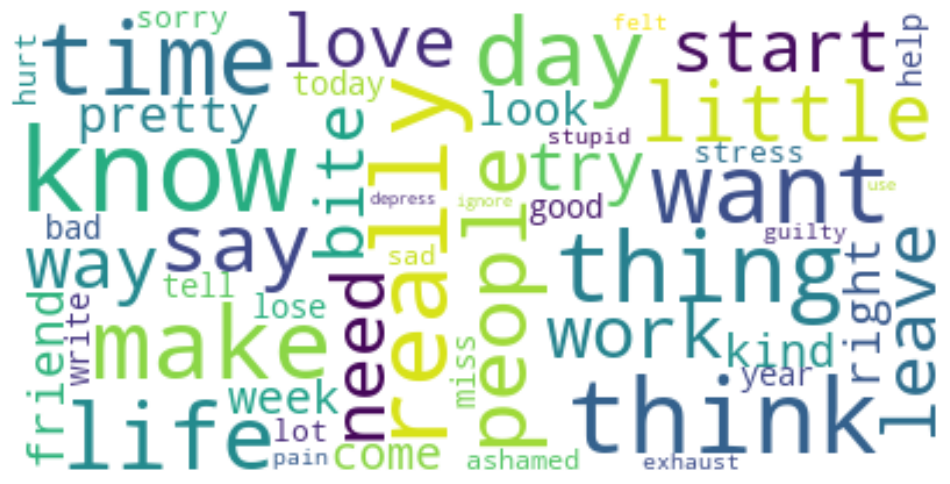

Word Cloud: anger


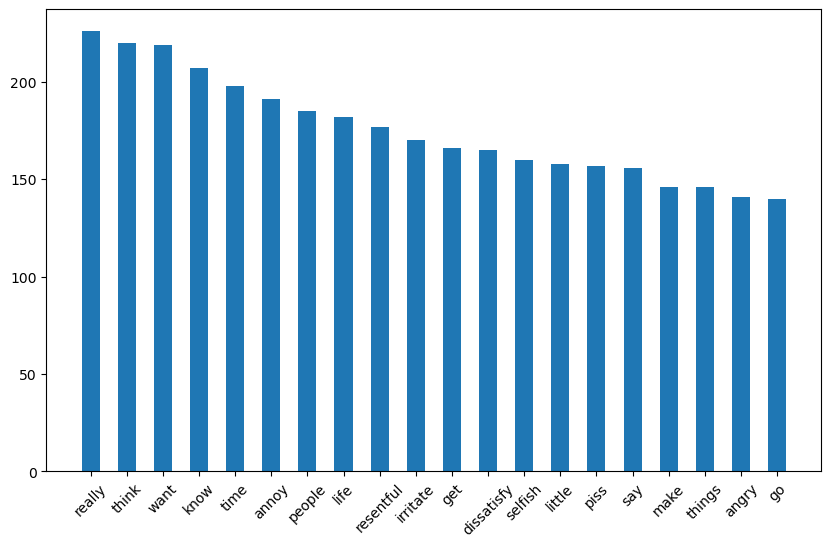

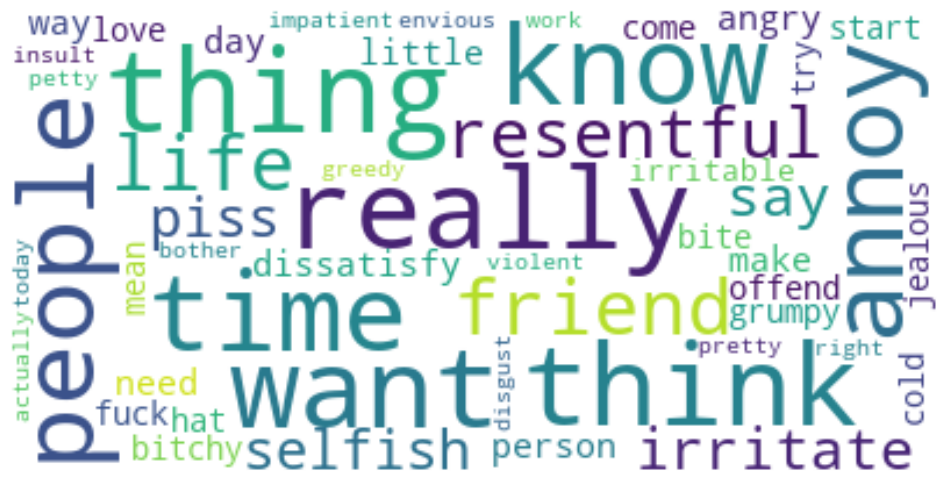

Word Cloud: fear


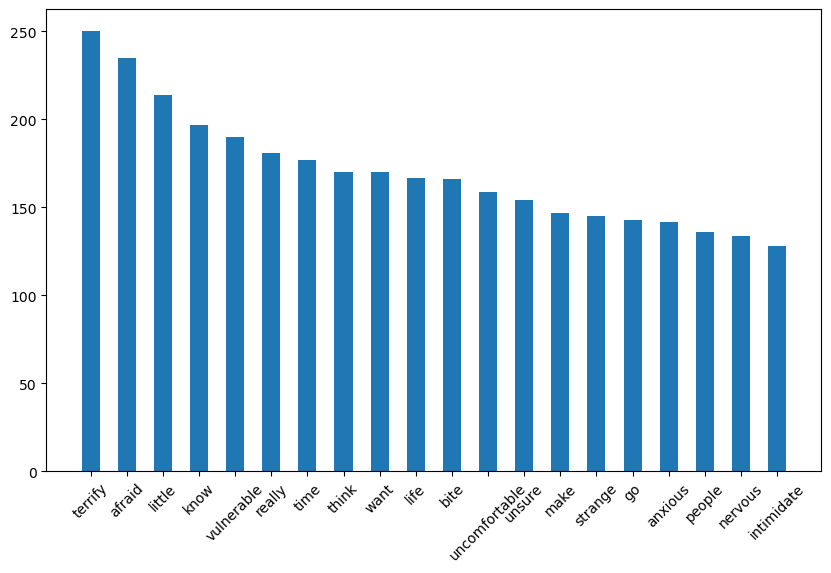

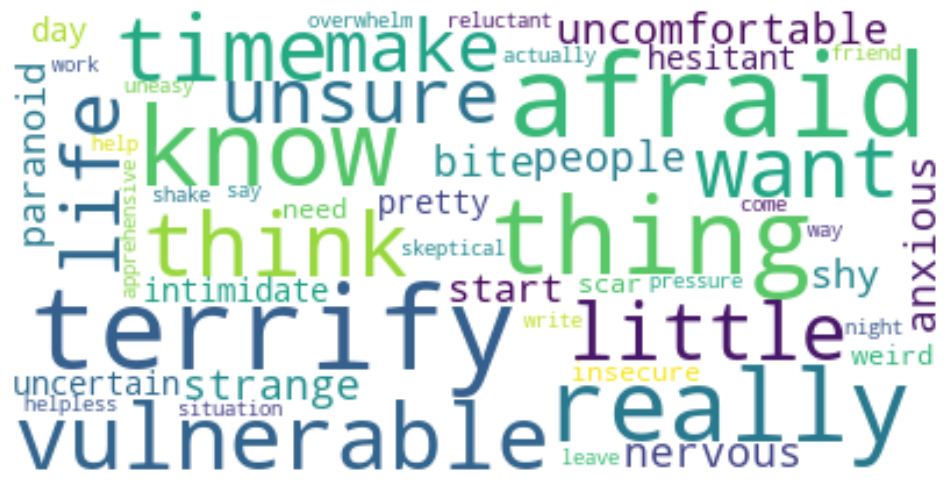

Word Cloud: love


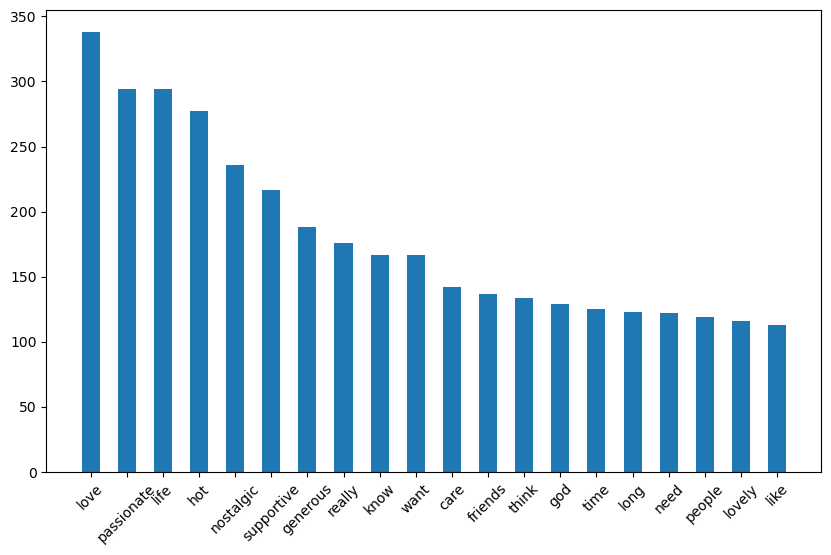

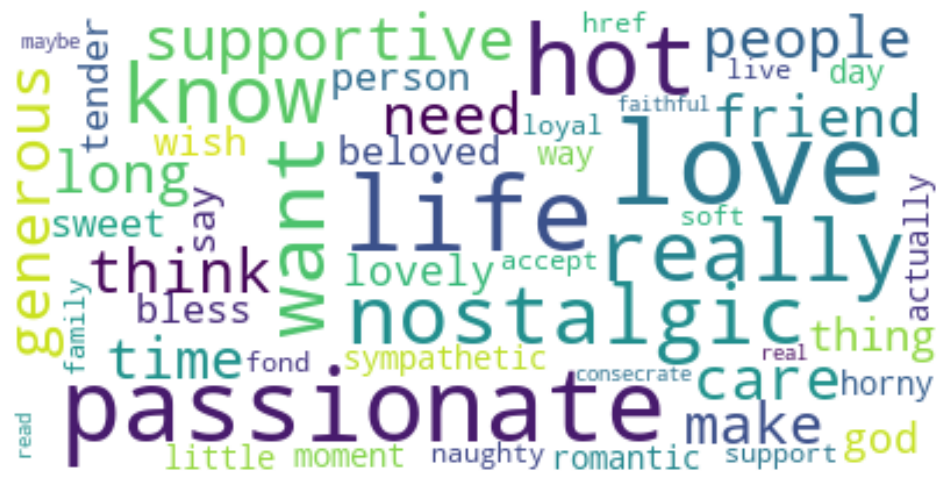

Word Cloud: surprise


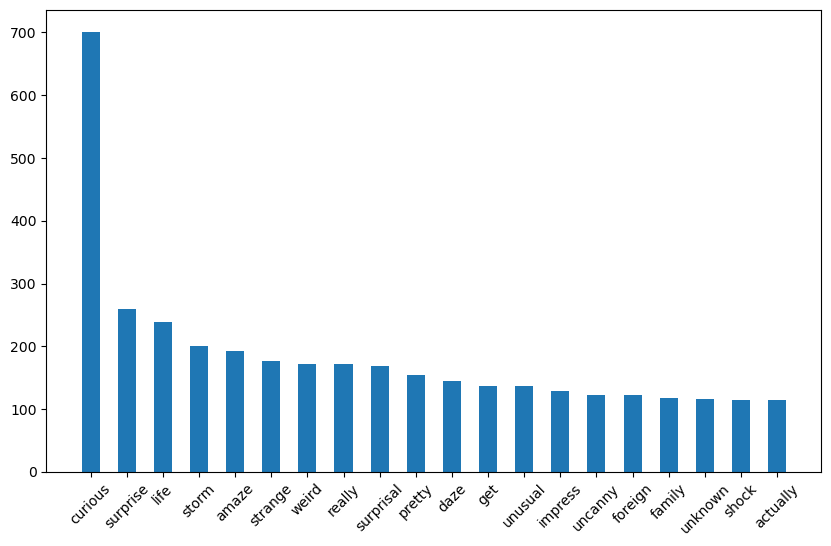

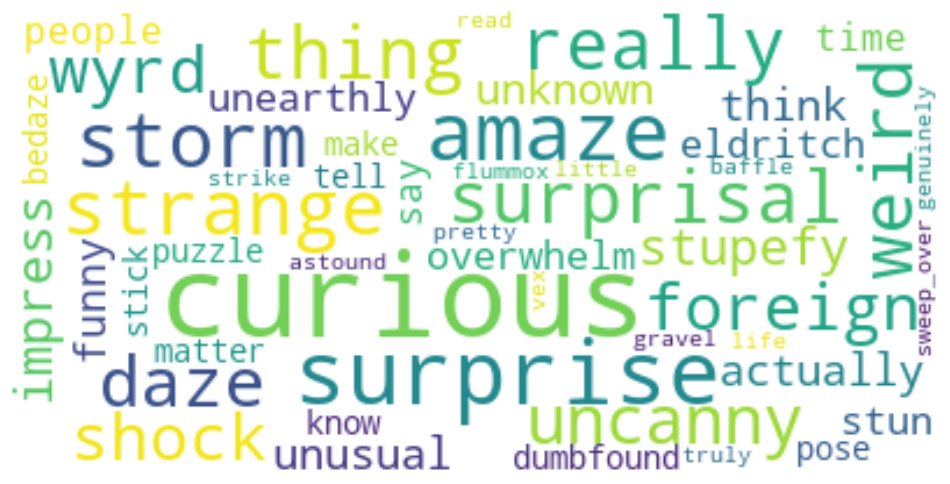

In [3]:
stop_words = STOPWORDS.union(stopwords.words("english")).union(ENGLISH_STOP_WORDS)

for sentiment in data["sentiment"].unique():
    print(f"Word Cloud: {sentiment}")

    data_labeled = data[data["sentiment"] == sentiment]
    corpus = " ".join([word for sublist in data_labeled["content"].str.split() for word in sublist])

    word_count = collections.Counter(corpus.split())
    top_pairs = sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:20]
    top_words = [pair[0] for pair in top_pairs]
    top_freq = [pair[1] for pair in top_pairs]

    xn = np.arange(len(top_pairs))
    fig = plt.figure(figsize=(10,6))
    ax = fig.gca()

    ax.bar(xn, top_freq, width=0.5, align="center")

    ax.set_xticks(xn)
    ax.set_xticklabels(top_words)
    plt.xticks(rotation=45)

    wordcloud = WordCloud(max_font_size=50, max_words=50,stopwords=stop_words, background_color="white").generate(corpus)

    plt.figure(figsize = (12, 12), facecolor = None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [4]:
def evaluate_model(y_expected, y_predicted):
    return accuracy_score(y_expected, y_predicted), precision_score(y_expected, y_predicted, average="macro"), recall_score(y_expected, y_predicted, average="macro"), f1_score(y_expected, y_predicted, average="macro")

x = data["content"]
y = data["sentiment"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

display(pd.DataFrame(x_train[:15]))
display(pd.DataFrame(x_test[:15]))

,content
8318,really devastate see witness things
26674,single handedly support tissue industry moment
27845,let cover story in_reality start physique like
8147,really rotten remind thankful good days
31981,middle refutable gracious now
31187,poorly attention_deficit_hyperactivity_disorde...
37726,certainly whirl baby-sit severalise expire per...
37392,unearthly ploughshare generator heavy insecuri...
7969,rush pack kit ready fly gambia tuesday instead...
37520,halt strange reality drove trigger-happy carni...


,content
14611,hear stories cold
29303,conceive percentage find_out time logan likely...
36647,curious gum_benjamin clit timberland gump curi...
38341,smile sleep_with simple duologue child logic e...
33223,seismic_disturbance appear sr. polecat counter...
26796,horny thigh high nylons
35081,especially chafe senesce eld serve somewhat su...
33573,puzzle accept turn_on mean inauspicious finall...
18025,overrefinement delilahlwl weigh 24-hour_interv...
2915,intelligent people ones pay attention world th...


In [5]:
stats = data["sentiment"].value_counts()
labels, weights = stats.index, stats.values
dummy_prediction = pd.Series(random.choices(labels, weights=weights, k=len(y_test)), name="dummy_prediction")

results = [["Dummy Classification"] + list(evaluate_model(y_test, dummy_prediction))]
dummy_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

display(dummy_results)

,Model,Accuracy,Precision,Recall,F1 Score
0,Dummy Classification,0.163119,0.163117,0.163078,0.163084


In [6]:
lr = Pipeline([("vect", TfidfVectorizer()), ("lr", LogisticRegression(max_iter=200))])
lr.fit(x_train, y_train)
y_predicted = lr.predict(x_test)

results = [["Logistic Regression"] + list(evaluate_model(y_test, y_predicted))]
logistic_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

display(logistic_results)

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.873429,0.874003,0.873605,0.872992


In [7]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

knn = Pipeline([("vect", TfidfVectorizer()), ("knn", KNeighborsClassifier(n_neighbors=35))])
knn.fit(x_train, y_train)
y_knn_predicted = knn.predict(x_test)

results = [["K Nearest Neighbor Classification"] + list(evaluate_model(y_test, y_knn_predicted))]
knn_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

display(knn_results)

,Model,Accuracy,Precision,Recall,F1 Score
0,K Nearest Neighbor Classification,0.804052,0.806763,0.804055,0.803134


In [8]:
rf = Pipeline([("vect", TfidfVectorizer()), ("rf", RandomForestClassifier(n_estimators=50))])
rf.fit(x_train, y_train)
y_forest_predicted = rf.predict(x_test)

results = [["Random Forest Classification"] + list(evaluate_model(y_test, y_forest_predicted))]
forest_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

display(forest_results)

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest Classification,0.829956,0.834035,0.830209,0.829537


In [9]:
svc = Pipeline([("vect", TfidfVectorizer()), ("svc", LinearSVC(C=0.5))])
svc.fit(x_train, y_train)
y_svc_predicted = svc.predict(x_test)

results = [["Linear Support Vector Classification"] + list(evaluate_model(y_test, y_svc_predicted))]
svc_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

display(svc_results)

,Model,Accuracy,Precision,Recall,F1 Score
0,Linear Support Vector Classification,0.888305,0.888718,0.888579,0.887865


In [10]:
all_results = pd.concat([dummy_results, logistic_results, knn_results, forest_results, svc_results]).reset_index(drop=True)
display(all_results)

,Model,Accuracy,Precision,Recall,F1 Score
0,Dummy Classification,0.163119,0.163117,0.163078,0.163084
1,Logistic Regression,0.873429,0.874003,0.873605,0.872992
2,K Nearest Neighbor Classification,0.804052,0.806763,0.804055,0.803134
3,Random Forest Classification,0.829956,0.834035,0.830209,0.829537
4,Linear Support Vector Classification,0.888305,0.888718,0.888579,0.887865
